### Import the library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_percentage_error,mean_absolute_error
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from prettytable import PrettyTable

### Load data

In [2]:
df = pd.read_csv("../data/laptop_final.csv")

In [3]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df2=df.drop(columns=["link","name","Total Score","Display Score","Portability Score","Play Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df2 = df2.drop_duplicates()

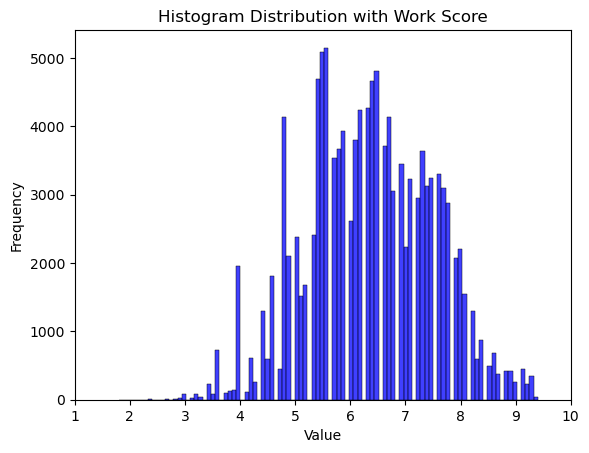

In [4]:
# play score distribution 
sns.histplot(df2['Work Score'], bins=100, color='blue')

plt.title("Histogram Distribution with Work Score")
plt.xlabel("Value")
plt.xlim(1,10)
plt.ylabel("Frequency")

plt.show()

#### Drop nan values

In [5]:
df2.isna().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 263
RAM Type                                   27120
OS                                           665
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [6]:
df3 = df2.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is:{} and after drop nan values is:{}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is:289171 and after drop nan values is:157767


### Add more features following our knowledge about laptop architecture


+ **CPU Processing Power** (Ghz)= CPU: Core x CPU: Base Frequency
   
      - CPU: Core is the number of core in CPU 
      - CPU: Base Frequency is the speed where each core operates (GHz)
  
  ⇒ This feature tells the total number of cycles the CPU can operate in a second (Ghz)

+ **GPU Band Width** (bits/s) = GPU: Memory Frequency × GPU: Memory Bus 
  
      - GPU: Memory Frequency is the clock speed of GPU memory (Mhz)
      - GPU: Memory Bus is the number of bits the memory can transfer per clock cycle (bits/cycle)
  
  ⇒ Represent how fast data can move between the GPU memory and the GPU’s cores for processing (bits/s)

+ **GPU Efficiency** (cycles/J) = GPU: Base Clock / GPU: Power Consumption

      -GPU: Base Clock is the clock speed of GPU core (Ghz)
      -GPU: Power Consumption is the power GPU uses during operation (W)

  ⇒ Represent how much work GPU can do per unit of energy consumption (cycles/J)

In [7]:
df3["CPU: Processing Power"]=df3["CPU: Core"]*df3["CPU: Base frequency"]
df3["GPU: Band Width"]=df3["GPU: Memory Frequency (MHz)"]*df3["GPU: Memory Bus"]
df3["GPU: Efficiency"]=df3["GPU: Base Clock"]/df3["GPU: Power Consumption"]
added_features=["CPU: Processing Power","GPU: Band Width","GPU: Efficiency"]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38288\2940952750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["CPU: Processing Power"]=df3["CPU: Core"]*df3["CPU: Base frequency"]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38288\2940952750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["GPU: Band Width"]=df3["GPU: Memory Frequency (MHz)"]*df3["GPU: Memory Bus"]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38288\2940952750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

#### Train Test split 

In [8]:
target="Work Score"
X=df3.drop(columns=[target])
y=df3[target]

In [9]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

#### Encode categorical columns using target encoding

In [10]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df3[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [11]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

### Features Selection

In [12]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]+added_features          
categorical_features=list(set(df3.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Backlit keyboard', 'Body material: plastic', 'GPU: Architecture', 'Body material: magnesium alloy', 'HDD', 'Body material: magnesium-lithium alloy', 'Fingerprint reader', 'Optane', 'Body material: plastic / polycarbonate', 'Card Reader', 'SSHD', 'Body material: carbon', 'Body material: aluminum', 'Security Lock slot', 'SSD', 'Body material: matte', 'RAM Type', 'Body material: black synthetic material', 'GPU: Memory Type', 'OS', 'Body material: glass fiber', 'Panel Type']
22


* Normalize for features selection

In [13]:
normalized_X_train = X_train.copy()
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train.head(5)

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,CPU: Processing Power,GPU: Band Width,GPU: Efficiency
69483,0.250412,-0.291859,0.067488,-0.675571,6.245898,-0.566839,1.0,0.0,0.0,0.0,...,5.474121,-0.528519,-0.881114,-0.979481,-0.953013,-0.333554,-0.910767,0.755533,-0.474989,0.197542
138264,-0.117391,-0.291859,-0.351080,-0.675571,6.245898,0.418173,1.0,0.0,0.0,0.0,...,5.474121,-0.528519,-0.881114,-0.979481,-0.953013,-0.333554,-0.910767,-0.617934,-0.474989,0.197542
136293,-0.117391,-0.291859,-0.351080,-0.675571,6.245898,2.397700,1.0,0.0,0.0,0.0,...,7.103775,-0.258127,0.171112,0.421571,0.434906,-0.599200,-0.175613,-0.577538,-0.292724,0.267356
182777,-1.588604,-0.291859,-0.351080,-0.675571,6.245898,-0.566839,1.0,0.0,0.0,0.0,...,5.474121,-0.528519,-0.881114,-0.979481,-0.953013,-0.333554,-0.910767,-0.819915,-0.474989,0.197542
79805,-1.588604,-0.291859,-0.351080,-0.675571,6.245898,-0.373637,1.0,0.0,0.0,0.0,...,5.474121,-0.528519,-0.881114,-0.979481,-0.953013,-0.333554,-0.910767,-0.072587,-0.474989,0.197542


* Using mutual info and anova to find the most relevant categorical features

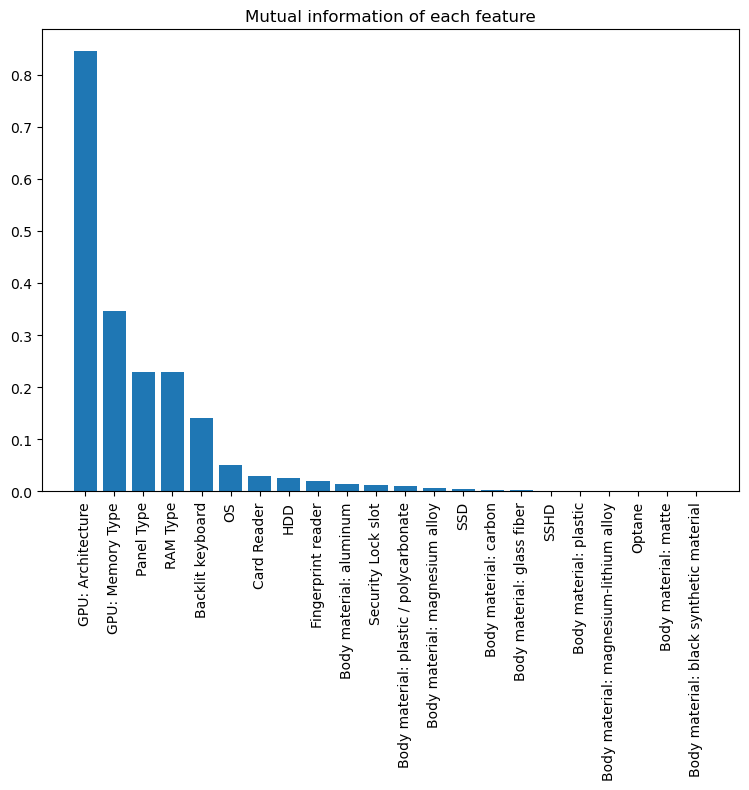

In [14]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 1 15 17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


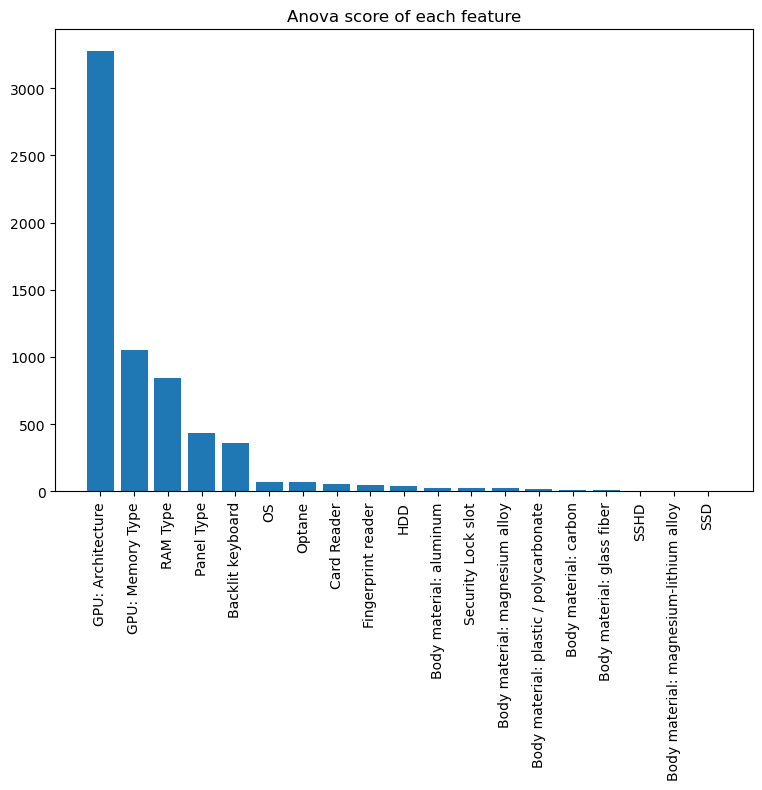

In [15]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

* Using pearson correlation, spearman to find the most relevant in numerical features

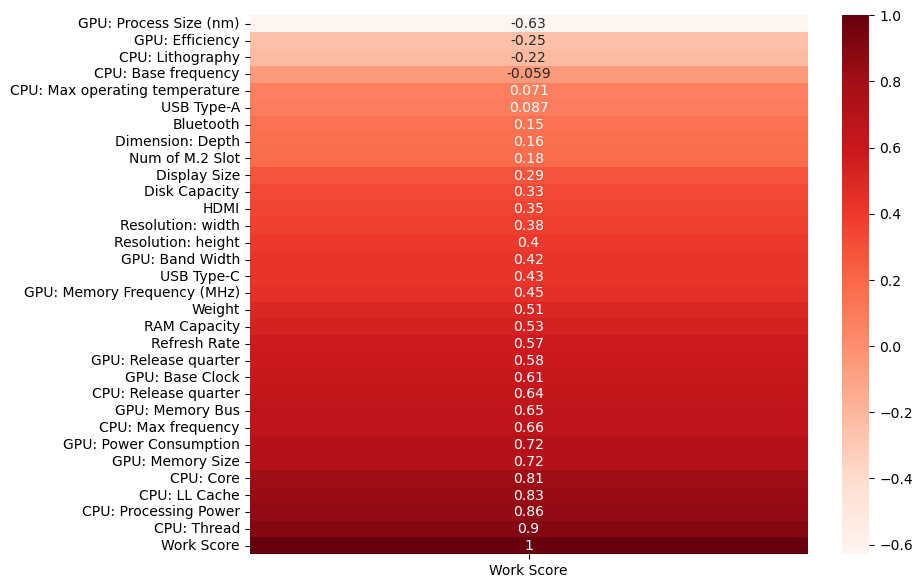

In [16]:
# using pearsonscore
train_set=normalized_X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

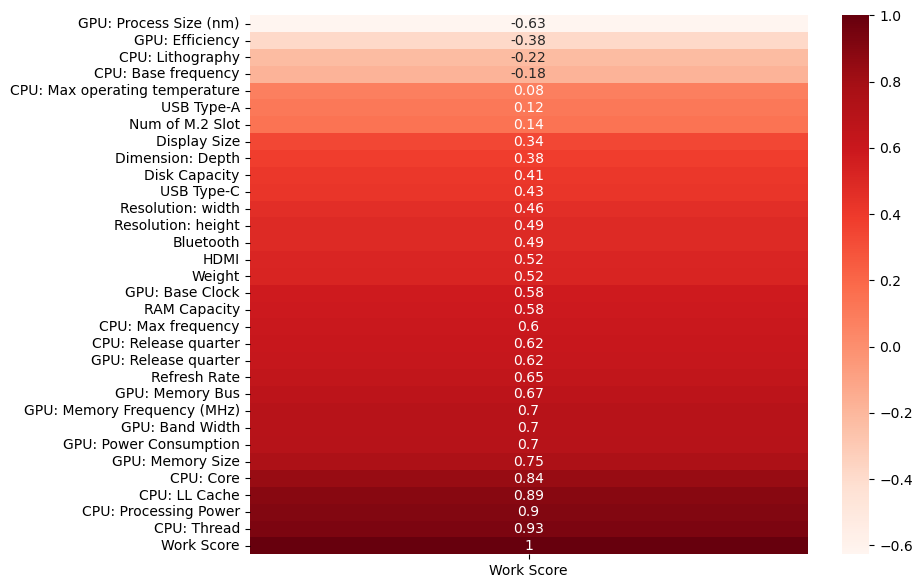

In [17]:
# using spearman score
train_set=normalized_X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

* Using Permutation Importance method to choose important features in 2 groups

In [19]:
# Choose candidate features in 2 groups
candidate_num_features = [f for f in target_correlation.index if abs(target_correlation[target].loc[f])>=0.5 and f!=target]
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['GPU: Architecture', 'GPU: Memory Type', 'Panel Type', 'RAM Type', 'Backlit keyboard', 'Refresh Rate', 'RAM Capacity', 'Weight', 'HDMI', 'CPU: Core', 'CPU: Thread', 'CPU: Max frequency', 'CPU: Release quarter', 'CPU: LL Cache', 'GPU: Process Size (nm)', 'GPU: Memory Frequency (MHz)', 'GPU: Memory Size', 'GPU: Base Clock', 'GPU: Memory Bus', 'GPU: Release quarter', 'GPU: Power Consumption', 'CPU: Processing Power', 'GPU: Band Width']


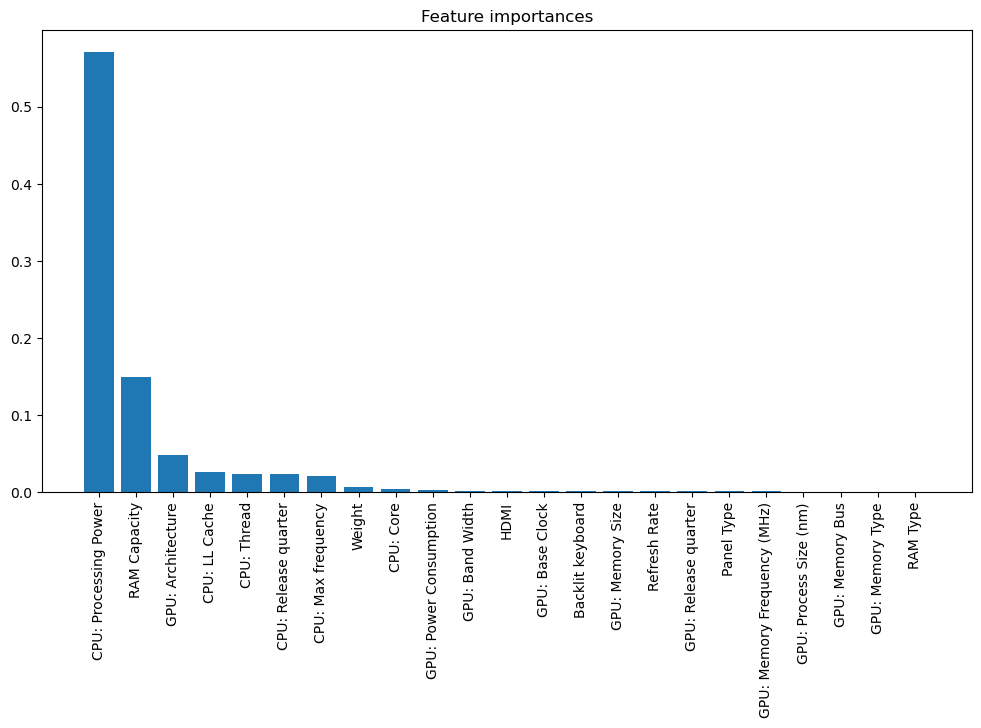

In [20]:
candidate_X = normalized_X_train[candidate_featues]
model_to_select_feature = RandomForestRegressor(n_estimators=5,min_samples_leaf=2)
model_to_select_feature.fit(candidate_X, y_train)
imp_dict = permutation_importance(model_to_select_feature,candidate_X,y_train,n_repeats=10,random_state=42,scoring="r2",n_jobs=-1)
imp_score=imp_dict.importances_mean
indices = np.argsort(imp_score)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature importances')
plt.bar(range(len(indices)), imp_score[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [21]:
#Choose importatn features based on the importance score in RF
final_features = [c for c in candidate_X.columns[indices[:10]]]
final_features

['CPU: Processing Power',
 'RAM Capacity',
 'GPU: Architecture',
 'CPU: LL Cache',
 'CPU: Thread',
 'CPU: Release quarter',
 'CPU: Max frequency',
 'Weight',
 'CPU: Core',
 'GPU: Power Consumption']

In [22]:
better_X_train=X_train[final_features]
better_X_test=X_test[final_features]

In [24]:
chosen_num_features = [ 'CPU: LL Cache',
 'CPU: Thread',
 'CPU: Release quarter',
 'CPU: Max frequency',
 'Weight',
 'GPU: Power Consumption',
 'CPU: Core','CPU: Processing Power',
 'RAM Capacity']
chosen_cat_features = ['GPU: Architecture']

#### Visualize

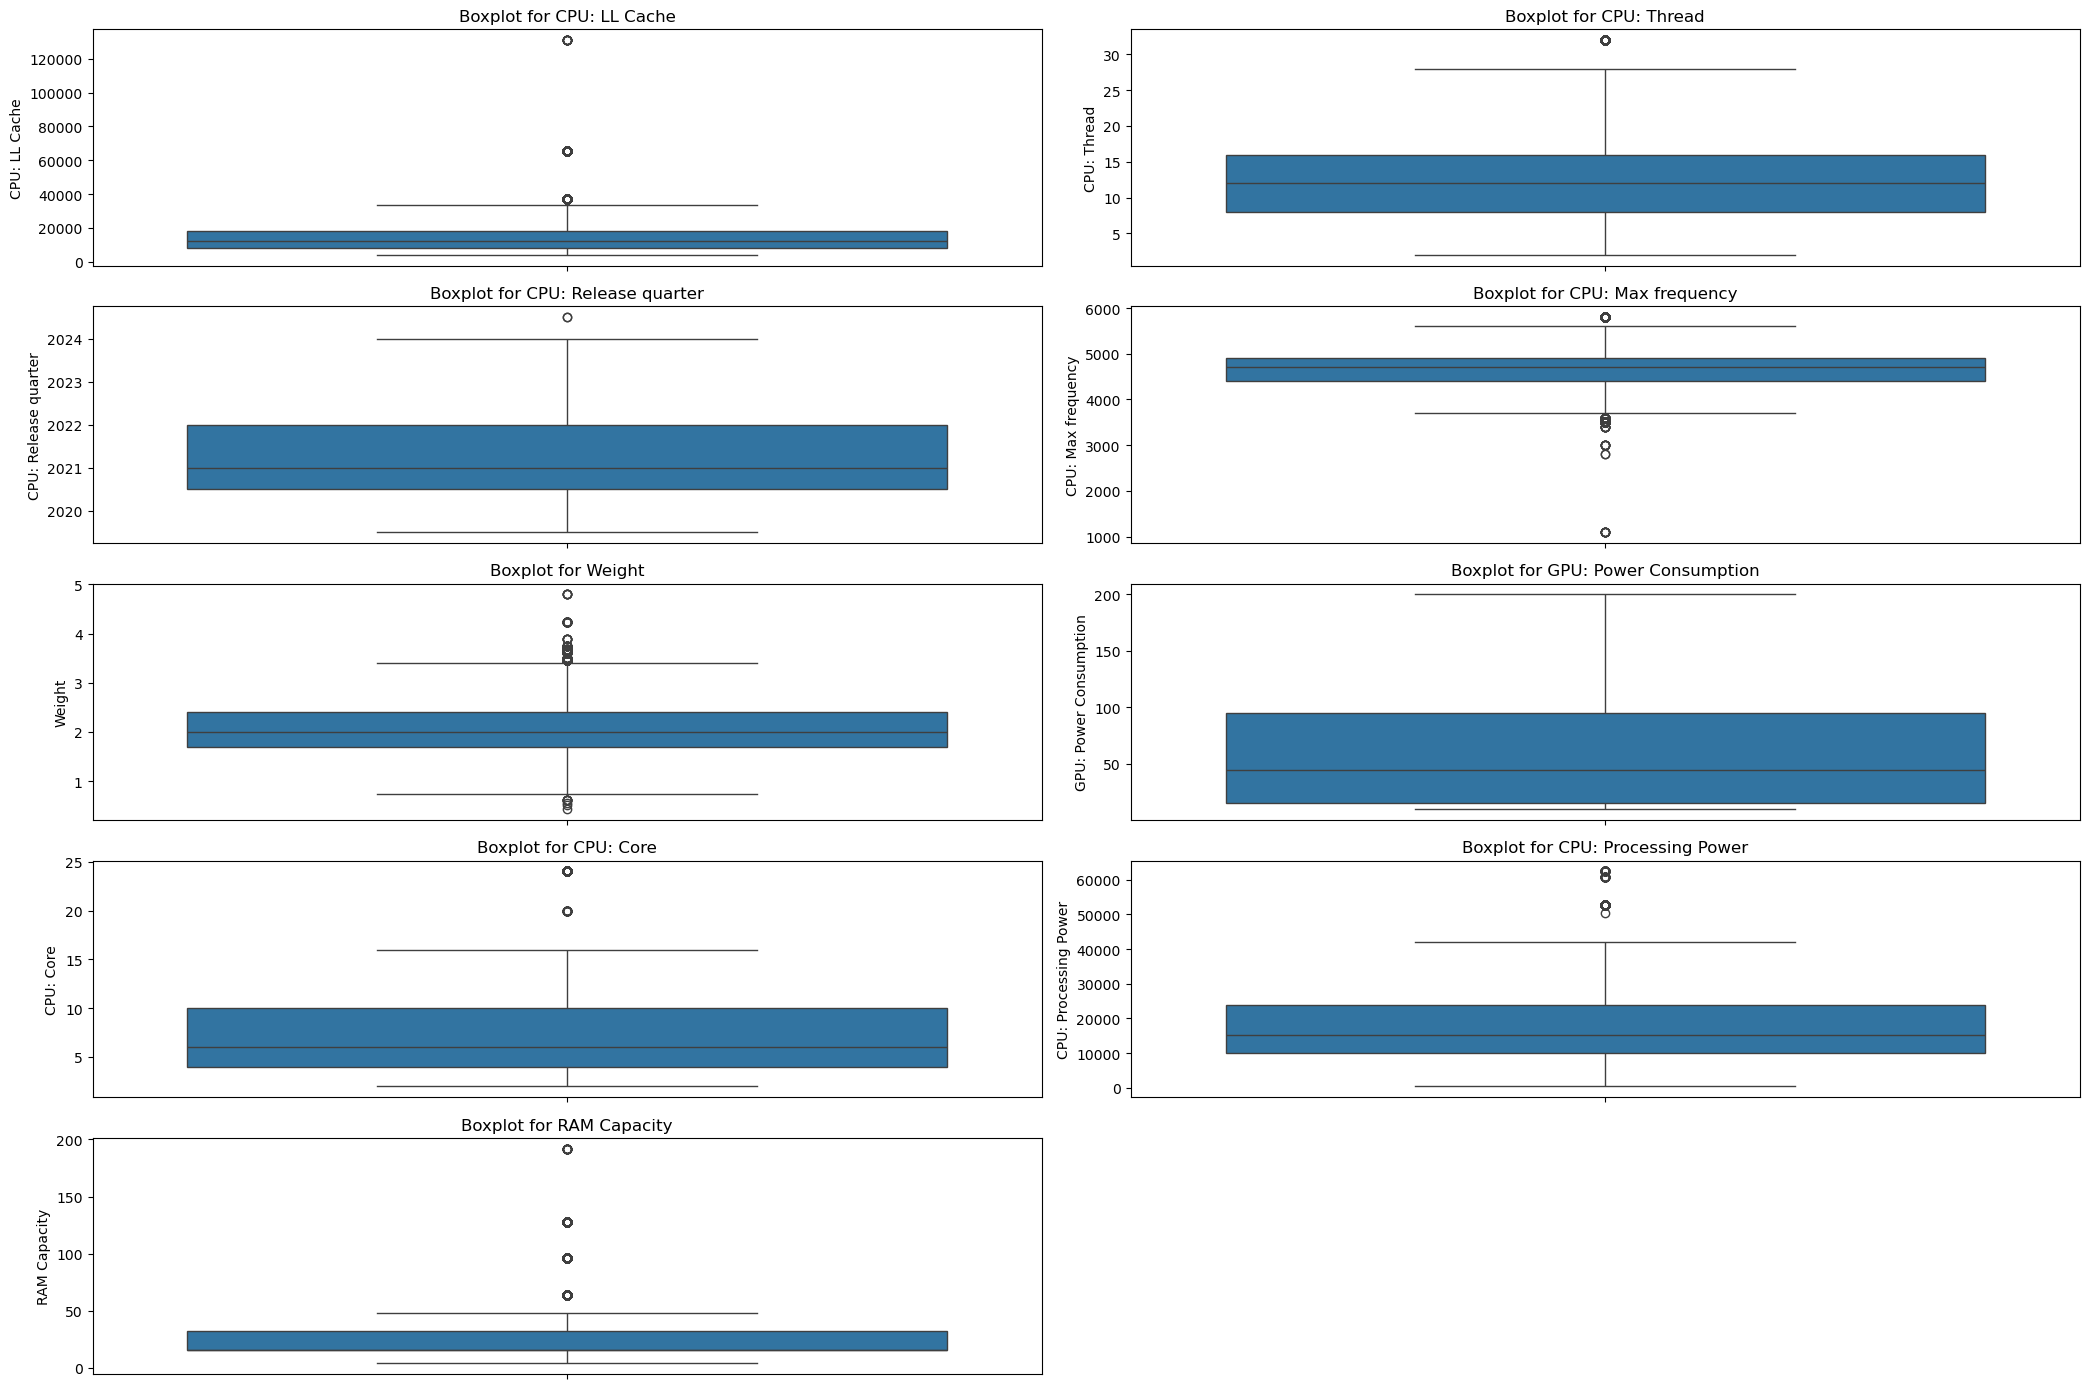

In [49]:
plt.figure(figsize=(21, 14))
for i, var in enumerate(chosen_num_features):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=X_train[var])  # Explicitly pass the column to x
    plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()

Distribution of each feature

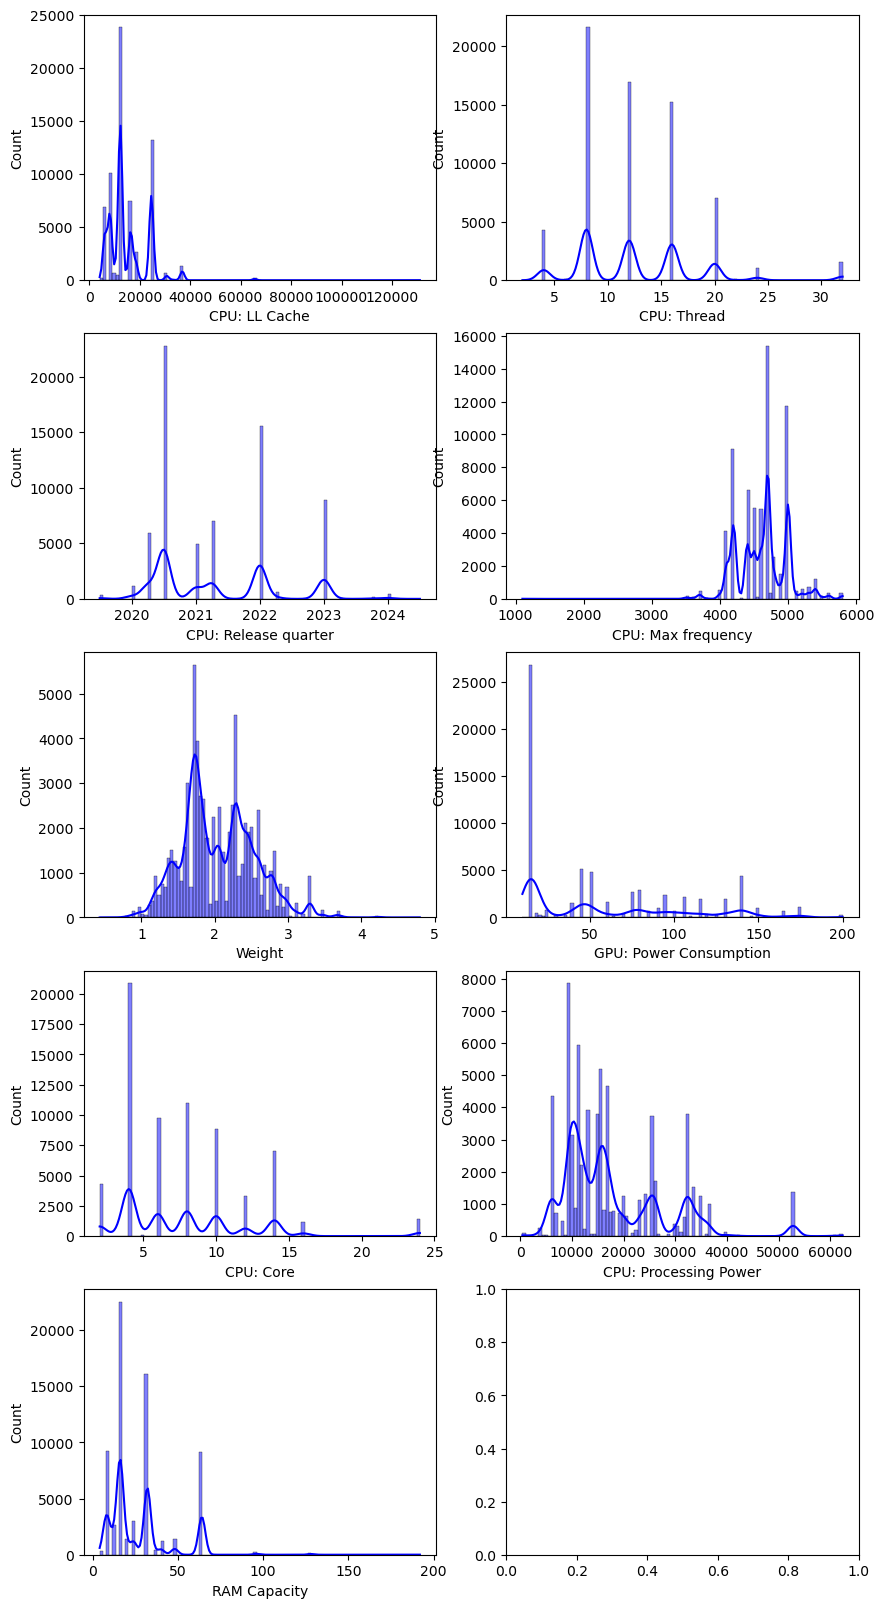

In [102]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
axes = axes.flatten() 
for i, column in enumerate(chosen_num_features):
    ax = axes[i]
    sns.histplot(better_X_train[column], kde=True, bins=100, color='blue', ax= ax)

Detect outliers

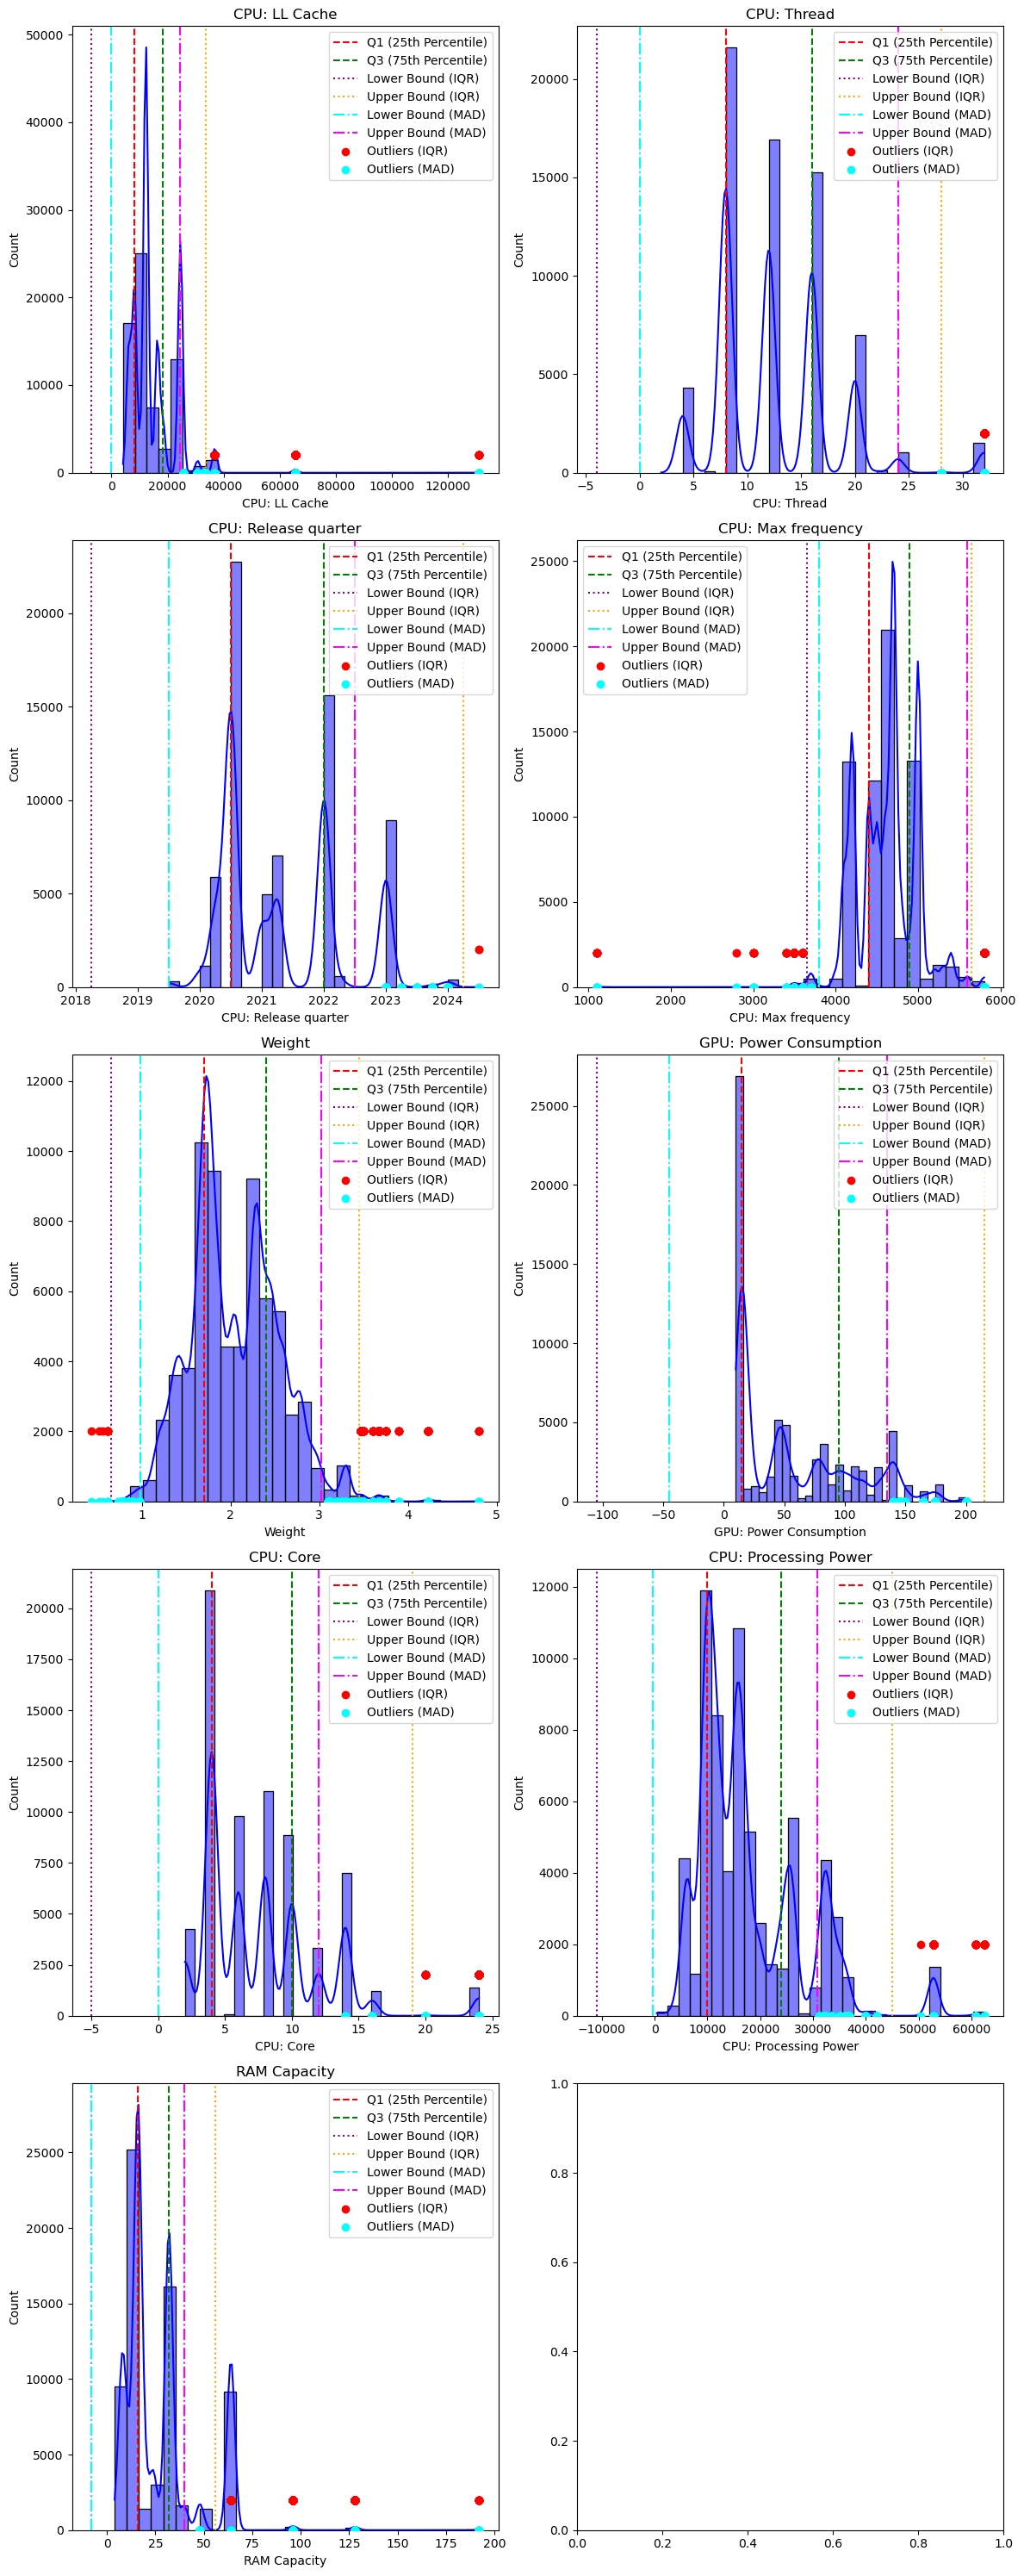

In [103]:
# visual outlier of data based on IQR and MAD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def detect_outliers(data):
    # IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    # MAD
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    lower_bound_mad = median - 3 * mad
    upper_bound_mad = median + 3 * mad
    return Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad
def plot_distribution(data, ax, title):
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(data)
    sns.histplot(data, kde=True, bins=30, color='blue', ax=ax)
    ax.axvline(Q1, color="red", linestyle="--", label="Q1 (25th Percentile)")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3 (75th Percentile)")

    ax.axvline(lower_bound_iqr, color="purple", linestyle=":", label="Lower Bound (IQR)")
    ax.axvline(upper_bound_iqr, color="orange", linestyle=":", label="Upper Bound (IQR)")
    ax.axvline(lower_bound_mad, color="cyan", linestyle="-.", label="Lower Bound (MAD)")
    ax.axvline(upper_bound_mad, color="magenta", linestyle="-.", label="Upper Bound (MAD)")

    iqr_outliers = data[(data < lower_bound_iqr) | (data > upper_bound_iqr)]
    mad_outliers = data[(data < lower_bound_mad) | (data > upper_bound_mad)]
    ax.scatter(iqr_outliers, [2000] * len(iqr_outliers), color="red", label="Outliers (IQR)", zorder=5)
    ax.scatter(mad_outliers, [0] * len(mad_outliers), color="cyan", label="Outliers (MAD)", zorder=5)
    ax.set_title(title)
    ax.legend()
n_features = len(chosen_num_features)
n_cols = 2  
n_rows = (n_features + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()  
for i in range(n_features):
    plot_distribution(better_X_train[chosen_num_features[i]], axes[i], chosen_num_features[i])
plt.tight_layout()
plt.show()

### Training

* Normalize

In [25]:
scaler = StandardScaler()
final_X_train=better_X_train.copy()
final_X_test=better_X_test.copy()
final_X_train[chosen_num_features] = scaler.fit_transform(better_X_train[chosen_num_features])
final_X_test[chosen_num_features] = scaler.transform(better_X_test[chosen_num_features])
final_y_train = y_train

In [26]:
print(final_X_train.shape)
print(final_X_test.shape)
print(final_y_train.shape)
print(y_test.shape)


(67824, 10)
(16956, 10)
(67824,)
(16956,)


* Model

In [27]:
models={
    model_name:{} for model_name in ["Ridge Regression","Gradient Boosting",'KNN','Random Forest',"SVM Regression"]
} 

* Grid Search

In [28]:
def best_params_finder(model, param_grid, cv=3, scoring='r2', X_train=final_X_train, y_train=final_y_train, X_test=final_X_test, y_test=y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1,return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    results_df = pd.DataFrame(grid_search.cv_results_)
    #print("\nDetailed Grid Search Results:")
    #print(results_df[['params','mean_train_score', 'std_train_score','mean_test_score', 'std_test_score','rank_test_score']])
    print(f"\nBest Parameters: {best_params}")
    print(f"Test Score with Best Estimator: {test_score}")
    return best_params

* K-Nearest Regresion

In [29]:
knn=KNeighborsRegressor()
params_grid_KNN = {
    'n_neighbors': [5,10,15,20],        
    'metric': ['euclidean', 'manhattan']}

In [30]:
best_params=best_params_finder(knn,params_grid_KNN)
knn.set_params(**best_params)
models["KNN"]["model"]=knn


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 10}
Test Score with Best Estimator: 0.9827594941261093


* Ridge Regression

In [31]:
ridge=Ridge()
params_grid_Ridge={"alpha":[0.1,0.05,0.01,0.005,0.001]}

In [32]:
best_params=best_params_finder(ridge,params_grid_Ridge)
ridge.set_params(**best_params)
models["Ridge Regression"]["model"]=ridge


Best Parameters: {'alpha': 0.01}
Test Score with Best Estimator: 0.9196859700512412


* Random Forest

In [33]:
rf=RandomForestRegressor()
params_grid_RF={"n_estimators":[10,25,50],"min_samples_leaf":[2,5],"min_samples_split":[2,5,10]}

In [34]:
best_params=best_params_finder(rf,params_grid_RF)
rf.set_params(**best_params)
models["Random Forest"]["model"]=rf


Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Test Score with Best Estimator: 0.9852807889667189


* Support Vector Machine

In [35]:
params_grid_SVM = {
    'C': [0.1,0.5,1]              
}
svr=SVR()

In [36]:
best_params=best_params_finder(svr,params_grid_SVM)
svr.set_params(**best_params)
models["SVM Regression"]["model"]=svr


Best Parameters: {'C': 1}
Test Score with Best Estimator: 0.9743425238696974


* Gradient Boosting Regression

In [37]:
gbr=GradientBoostingRegressor()
params_grid_GBR={"n_estimators":[100,200,500],"min_samples_leaf":[2,5],"min_samples_split":[2,5,10]}

In [38]:
best_params=best_params_finder(gbr,params_grid_GBR)
gbr.set_params(**best_params)
models["Gradient Boosting"]["model"]=gbr


Best Parameters: {'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Test Score with Best Estimator: 0.9845224835105796


* Result

In [39]:
def train(X_train=final_X_train, y_train=final_y_train, X_test=final_X_test, y_test=y_test):
    for name in models:
        print(f"Training and evaluating {name}...")
        model=models[name]["model"]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        mae=mean_absolute_error(y_test,y_pred)
        models[name]["result"]=[rmse,mae,mape]
def display_result():
    table = PrettyTable()
    table.field_names = ["Model","RMSE","MAE","MAPE"]
    for name in models:
        table.add_row([name,  f"{models[name]["result"][0]:.4f}", f"{models[name]["result"][1]:.4f}",f"{models[name]["result"][2]:.4f}"])
    print(table)

In [40]:
train()

Training and evaluating Ridge Regression...
Training and evaluating Gradient Boosting...
Training and evaluating KNN...
Training and evaluating Random Forest...
Training and evaluating SVM Regression...


In [41]:
display_result()

+-------------------+--------+--------+--------+
|       Model       |  RMSE  |  MAE   |  MAPE  |
+-------------------+--------+--------+--------+
|  Ridge Regression | 0.3420 | 0.2726 | 0.0469 |
| Gradient Boosting | 0.1501 | 0.1067 | 0.0189 |
|        KNN        | 0.1584 | 0.1006 | 0.0180 |
|   Random Forest   | 0.1463 | 0.0936 | 0.0169 |
|   SVM Regression  | 0.1933 | 0.1451 | 0.0256 |
+-------------------+--------+--------+--------+


### Inference

In [42]:
data_to_inference=final_X_test.join(df["link"]) 
data_to_inference

,CPU: Processing Power,RAM Capacity,GPU: Architecture,CPU: LL Cache,CPU: Thread,CPU: Release quarter,CPU: Max frequency,Weight,CPU: Core,GPU: Power Consumption,link
132607,-0.739128,-1.022085,5.612725,-0.885000,-0.831070,-0.311797,-0.626158,-0.818987,-0.835433,-0.910774,https://laptopmedia.com/laptop-specs/dell-vost...
22694,1.603863,0.255092,8.189956,1.248991,1.343276,1.771270,1.058711,-0.094750,1.454614,1.189684,https://laptopmedia.com/laptop-specs/lenovo-le...
204440,-0.658335,-1.022085,5.612725,-0.351502,-0.831070,-0.832563,0.216277,-0.798869,-0.835433,-0.910774,https://laptopmedia.com/laptop-specs/acer-aspi...
227370,-0.213975,0.255092,6.122677,-0.351502,-0.106288,-1.092947,1.058711,2.520551,-0.377424,0.454523,https://laptopmedia.com/laptop-specs/hp-omen-g...
73343,0.270782,-1.022085,5.612725,-0.351502,0.618494,0.729737,-0.626158,-1.321929,0.996605,-0.910774,https://laptopmedia.com/laptop-specs/asus-zenb...
...,...,...,...,...,...,...,...,...,...,...,...
141385,-1.062299,0.680818,5.490275,-0.618251,-0.831070,0.729737,-0.626158,-0.839105,-0.377424,-0.280637,https://laptopmedia.com/laptop-specs/lenovo-id...
189089,-0.819921,-0.596359,5.612725,-0.885000,-0.831070,-0.832563,-1.187780,-0.718398,-0.835433,-0.910774,https://laptopmedia.com/laptop-specs/hp-eliteb...
30775,0.634350,-0.596359,8.189956,1.248991,0.618494,1.771270,0.777899,-0.094750,0.538595,1.294706,https://laptopmedia.com/laptop-specs/asus-rog-...
251762,1.462476,-0.596359,7.375437,1.248991,1.343276,0.729737,0.216277,1.112312,1.454614,1.714798,https://laptopmedia.com/laptop-specs/asus-tuf-...


In [43]:
def predict(model_name,laptop_link,X_test=final_X_test,y_test=y_test):
    index=data_to_inference[data_to_inference["link"]==laptop_link].index[0]
    y_pred=models[model_name]["model"].predict(X_test.loc[index].values.reshape(1,-1))
    #y_pred =  y_scaler.inverse_transform(scaled_y_pred.reshape(-1, 1))[0][0]
    y_true=y_test.loc[index]
    print(f"Predicted {target}: ",f"{y_pred[0]:.4f}")
    print(f"True {target}: ",y_true)

In [44]:
predict("KNN",data_to_inference.loc[68555].link)

Predicted Work Score:  7.0000
True Work Score:  6.8


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
